In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_diffusion, evidence_meta_diffusion, plotting_settings
from src.python.helpers import load_simulated_rt_data, mask_inputs
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork
from src.python.visualization import plot_calibration_curve, plot_validation_results

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, mean_absolute_error
from functools import partial
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.facecolor'] = 'w'

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 
from bayesflow.losses import log_loss

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Validation

## Load in data

In [3]:
levy_sims_folder = 'c:\\Users\\lasse\\documents\\hierarchical model comparison project\\data\\Levy_flight_application'

val_indices_900_filename = "val_indices_900_trials.npy"
val_datasets_900_filename = "val_datasets_900_trials.npy"

val_indices_900, val_datasets_900 = load_simulated_rt_data(levy_sims_folder, val_indices_900_filename, val_datasets_900_filename)

# Split validation datasets into 2 parts so that GPU does not blow up during prediction
val_datasets_900_1 = val_datasets_900[:4000,:,:,:]
val_datasets_900_2 = val_datasets_900[4000:8000,:,:,:]

In [4]:
# TODO: Test validation for different amounts of missing values
# 0%, 3.17% (-> as in data, missings_mean=28.5), 10% (-> missings_mean=90), 20% (-> missings_mean=180)?

# Apply masking to validation data if desired
mask_val_data = True

missing_rts_equal_mean = True

if mask_val_data:
    val_datasets_900_1 = mask_inputs(val_datasets_900_1, missings_mean=28.5, missings_sd=13.5, missing_rts_equal_mean=missing_rts_equal_mean)
    val_datasets_900_2 = mask_inputs(val_datasets_900_2, missings_mean=28.5, missings_sd=13.5, missing_rts_equal_mean=missing_rts_equal_mean)

## Load in trained network

In [5]:
summary_net = HierarchicalInvariantNetwork(summary_meta_diffusion)
evidence_net = EvidentialNetwork(evidence_meta_diffusion)
amortizer = MultiModelAmortizer(evidence_net, summary_net)

# Checkpoint path for loading pretrained network and saving the final network
trial_folder = 'trial_4'
checkpoint_path = os.path.join(os.getcwd(), 'training_checkpoints', trial_folder)

trainer = ModelComparisonTrainer(
    network=amortizer, 
    loss=partial(log_loss, kl_weight=0),
    optimizer=partial(Adam),
    checkpoint_path=checkpoint_path,
    skip_checks=True
    )

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from c:\Users\lasse\Dropbox\Uni Mannheim\M.Sc\4. Semester\Masterarbeit\Coding\notebooks\03_levy_flight_application\training_checkpoints\trial_4\ckpt-64


## Predict

In [6]:
# Predict
probs_900_1 = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'] 
                    for x_chunk in tf.split(val_datasets_900_1, 500)], axis=0).numpy()
probs_900_2 = tf.concat([evidence_net.predict(summary_net(x_chunk))['m_probs'] 
                    for x_chunk in tf.split(val_datasets_900_2, 500)], axis=0).numpy()
probs_900 = tf.concat([probs_900_1, probs_900_2], axis=0).numpy()

In [7]:
# Transform predictions and indices
rounded_predictions_900 = tf.one_hot(tf.argmax(probs_900, axis=1), depth=4)
rounded_predictions_flat_900 = tf.argmax(probs_900, axis=1)
true_models_flat_900 = tf.argmax(val_indices_900, axis=1)

In [8]:
# Export predictions
export_predictions = False

if export_predictions:
    local_timezone = datetime.now(timezone(timedelta(0))).astimezone().tzinfo
    filename = pd.Timestamp.today(tz=local_timezone).strftime('%Y_%m_%d___%H_%M_predictions_finetuned_900_robust')
    val_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', 'Levy_flight_application')

    np.save(os.path.join(val_folder, filename), probs_900)

In [9]:
# Load in predictions
load_predictions = False

if load_predictions:
    val_folder = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'data', 'Levy_flight_application')
    filename = "2022_04_12___16_32_predictions_finetuned_900_robust.npy"
    probs_900 = np.load(os.path.join(val_folder, filename))

    rounded_predictions_900 = tf.one_hot(tf.argmax(probs_900, axis=1), depth=4)
    rounded_predictions_flat_900 = tf.argmax(probs_900, axis=1)
    true_models_flat_900 = tf.argmax(val_indices_900, axis=1)

### Results

In [10]:
# Accuracy & MAE
accuracy = tf.reduce_sum(tf.cast(rounded_predictions_flat_900 == true_models_flat_900, tf.float32))/len(true_models_flat_900)
mae = mean_absolute_error(val_indices_900, probs_900)
print('Accuracy = {}, MAE = {}'.format(accuracy, mae))

Accuracy = 0.8427500128746033, MAE = 0.14246952533721924


Text(23.499999999999993, 0.5, 'True model')

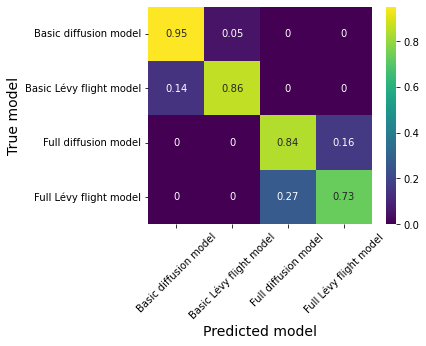

In [11]:
# Confusion matrix 

cm = confusion_matrix(true_models_flat_900, rounded_predictions_flat_900)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = cm.round(2)

labels = ['Basic diffusion model',
          'Basic Lévy flight model',
           'Full diffusion model',
           'Full Lévy flight model']
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize = (5,4))
sns.heatmap(df_cm, annot=True, cmap='viridis')
plt.xticks(rotation=45)
plt.xlabel('Predicted model', fontsize=plotting_settings['fontsize_labels'])
plt.ylabel('True model',fontsize=plotting_settings['fontsize_labels'])
#plt.savefig('Diffusion_conf_matrix.png', dpi=300, bbox_inches='tight')

ECE = 0.084
ECE = 0.094
ECE = 0.077
ECE = 0.077


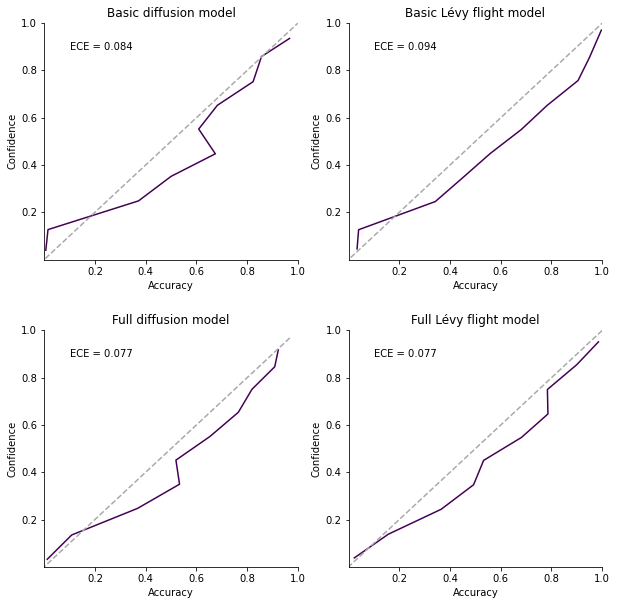

In [12]:
# Calibration curves

fig, axarr = plt.subplots(2, 2, figsize=(10, 10))
n_cal_bins = 15
plt.subplots_adjust(hspace = .3)
pos1 = [0,0,1,1]
pos2 = [0,1,0,1]
labels = ['Basic diffusion model',
          'Basic Lévy flight model',
           'Full diffusion model',
           'Full Lévy flight model']

for m in range(4):
    m_true = val_indices_900[:,m]
    m_soft = probs_900[:,m]
    plot_calibration_curve(m_true, m_soft, 10, pub_style=True, ax=axarr[pos1[m], pos2[m]],
                             title=labels[m], show_ece=True)
    

In [13]:
# Get the percentual occurence of different numbers of unique predictions over all data sets
uniques_per_row = [len(np.unique(probs_900[row,:])) for row in range(probs_900.shape[0])]
[[x,uniques_per_row.count(x)/8000] for x in [1,2,3,4]]

[[1, 0.0], [2, 0.140125], [3, 0.04775], [4, 0.812125]]

#### Plot all validation results in one figure

ECE = 0.084
ECE = 0.094
ECE = 0.077
ECE = 0.077


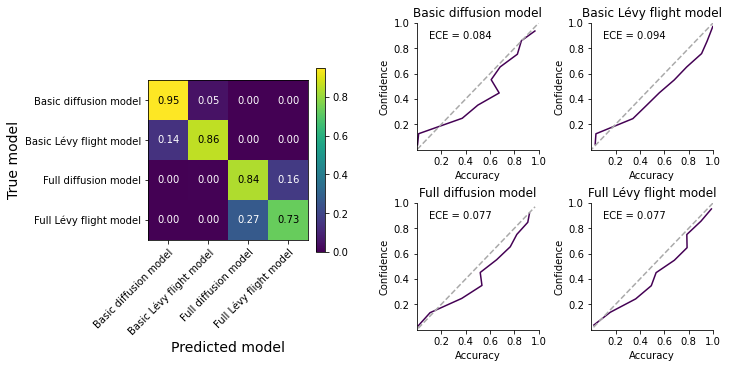

In [14]:
labels = ['Basic diffusion model',
          'Basic Lévy flight model',
           'Full diffusion model',
           'Full Lévy flight model']

plot_validation_results(true_models=val_indices_900, preds=probs_900, labels=labels, save=True)